In [14]:
#import dependencies
import keras
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Embedding, Conv1D, GlobalMaxPool1D, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
#set hyperparameters
output_dir = 'model_output/conv'

#training
epochs = 4
batch_size = 128

#vector-space embedding
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

#convolutional layer architecture
n_conv = 256 #filters, aka kernels
k_conv = 3 #kernel length

#dense layer architecture
n_dense = 256
dropout = 0.2

In [16]:
#model architecture
model = Sequential()

#vector-space embedding:
model.add(Embedding(n_unique_words, n_dim,
                    input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

#convolutional layer:
model.add(Conv1D(n_conv, k_conv, activation='relu'))
#model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPool1D())

#dense layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

#output layer
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 64)           320000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 400, 64)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 398, 256)          49408     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [18]:
#data preprocessing
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)
#standardizing input length by padding and truncating
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
#Create an object and directory for checkpoint model parameters after each epoch
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/CNNweights.{epoch:02d}.hdf5")

if not os.path.exists((output_dir)):
    os.makedirs(output_dir)

In [21]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 21s 104ms/step - loss: 0.4864 - accuracy: 0.7452 - val_loss: 0.2947 - val_accuracy: 0.8764
Epoch 2/4
196/196 [==============================] - 20s 101ms/step - loss: 0.2458 - accuracy: 0.9011 - val_loss: 0.2586 - val_accuracy: 0.8928
Epoch 3/4
196/196 [==============================] - 20s 102ms/step - loss: 0.1657 - accuracy: 0.9379 - val_loss: 0.2611 - val_accuracy: 0.8950
Epoch 4/4
196/196 [==============================] - 21s 106ms/step - loss: 0.1154 - accuracy: 0.9586 - val_loss: 0.2906 - val_accuracy: 0.8917


In [22]:
model.load_weights(output_dir+"/CNNweights.02.hdf5")

In [23]:
y_hat = model.predict_on_batch(x_valid)

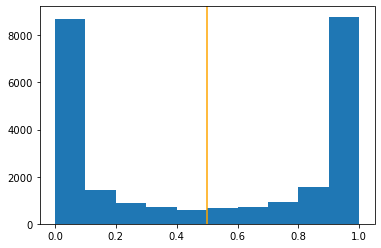

In [24]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [25]:
pct_auc = roc_auc_score(y_valid, y_hat) * 100
"{:0.2f}".format(pct_auc)

'95.94'